# Transect of results and observations


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import pandas as pd 
import warnings
import pickle
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
warnings.filterwarnings('ignore')

%matplotlib inline

###### Parameters:

In [2]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

# model results:
year           = 2015
month          = 8
results_folder = f'/data/brogalla/run_storage/Mn-reference-202103/ref-{year}-202103/'

# colours:
land_color = "#8b7765"

###### Load files:

In [3]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [4]:
Mn_model     = nc.Dataset(f'{results_folder}ANHA12_EXH006_{year}_monthly.nc')
mn_dis       = np.array(Mn_model.variables['dissolmn'])
lat_model    = np.array(Mn_model.variables['nav_lat'])
lon_model    = np.array(Mn_model.variables['nav_lon'])
depths_model = np.array(Mn_model.variables['deptht'])

Observations

In [5]:
Mn_data  = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Mn_Integrated_Data_UBC-UVic_4-17-19.csv')

dMn_BB1  = Mn_data['BB1'].dropna()[1:].astype('float'); dMn_BB2 = Mn_data['BB2'].dropna()[1:].astype('float');
dMn_BB3  = Mn_data['BB3'].dropna()[1:].astype('float'); dMn_CB1 = Mn_data['CB1'].dropna()[1:].astype('float');
dMn_CB2  = Mn_data['CB2'].dropna()[1:].astype('float'); dMn_CB3 = Mn_data['CB3'].dropna()[1:].astype('float');
dMn_CB4  = Mn_data['CB4'].dropna()[1:].astype('float'); dMn_CAA1 = Mn_data['CAA1'].dropna()[1:].astype('float');
dMn_CAA2 = Mn_data['CAA2'].dropna()[1:].astype('float'); dMn_CAA3 = Mn_data['CAA3'].dropna()[1:].astype('float');
dMn_CAA4 = Mn_data['CAA4'].dropna()[1:].astype('float'); dMn_CAA5 = Mn_data['CAA5'].dropna()[1:].astype('float');
dMn_CAA6 = Mn_data['CAA6'].dropna()[1:].astype('float'); dMn_CAA7 = Mn_data['CAA7'].dropna()[1:].astype('float');
dMn_CAA8 = Mn_data['CAA8'].dropna()[1:].astype('float'); dMn_CAA9 = Mn_data['CAA9'].dropna()[1:].astype('float');

depth_BB1  = Mn_data['Depth.2'].dropna(); depth_BB2 = Mn_data['Depth.3'].dropna();
depth_BB3  = Mn_data['Depth.4'].dropna(); depth_CB1 = Mn_data['Depth.14'].dropna();
depth_CB2  = Mn_data['Depth.15'].dropna(); depth_CB3 = Mn_data['Depth.16'].dropna();
depth_CB4  = Mn_data['Depth.17'].dropna(); depth_CAA1 = Mn_data['Depth.5'].dropna();
depth_CAA2 = Mn_data['Depth.6'].dropna(); depth_CAA3 = Mn_data['Depth.7'].dropna();
depth_CAA4 = Mn_data['Depth.8'].dropna(); depth_CAA5 = Mn_data['Depth.9'].dropna();
depth_CAA6 = Mn_data['Depth.10'].dropna(); depth_CAA7 = Mn_data['Depth.11'].dropna();
depth_CAA8 = Mn_data['Depth.12'].dropna(); depth_CAA9 = Mn_data['Depth.13'].dropna();

In [6]:
Pb_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons      = Pb_data['station lon'].astype('float').dropna().values
lats      = Pb_data['Station lat'].astype('float').dropna().values

###### Functions:

In [7]:
def find_closest_model_point(
    lon, lat, model_lons, model_lats, grid='NEMO', land_mask=None,
    tols={
        'NEMO': {'tol_lon': 0.104, 'tol_lat': 0.0388},
        'GEM2.5': {'tol_lon': 0.016, 'tol_lat': 0.012},
        }
):

    if grid not in tols:
        raise KeyError(
            'The provided grid type is not in tols. '
            'Use another grid type or add your grid type to tols.')

    # Search for a grid point with longitude and latitude within
    # tolerance of measured location
    j_list, i_list = np.where(
        np.logical_and(
            (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
                            model_lons < lon + tols[grid]['tol_lon'])),
            (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
                            model_lats < lat + tols[grid]['tol_lat']))
        )
    )

    if len(j_list) == 0:
        # Added by BMM March 2017
        # If including points outside of domain:
        return np.nan, np.nan
        # raise ValueError(
        #    'No model point found. tol_lon/tol_lat too small or '
        #    'lon/lat outside of domain.')
    try:
        j, i = map(np.asscalar, (j_list, i_list))
    except ValueError:
        # Several points within tolerance
        # Calculate distances for all and choose the closest

        # Avoiding array indexing because some functions
        # pass in model_lons and model_lats as netcdf4 objects
        # (which treat 'model_lons[j_list, i_list]' differently)
        lons = [model_lons[j_list[n], i_list[n]] for n in range(len(j_list))]
        lats = [model_lats[j_list[n], i_list[n]] for n in range(len(j_list))]
        dists = haversine(
            np.array([lon] * i_list.size), np.array([lat] * j_list.size),
            lons, lats)
        n = dists.argmin()
        j, i = map(np.asscalar, (j_list[n], i_list[n]))

    # If point is on land and land mask is provided
    # try to find closest water point
    if land_mask is None or not land_mask[j, i]:
        return j, i
    try:
        return _spiral_search_for_closest_water_point(
            j, i, land_mask, lon, lat, model_lons, model_lats)
    except ValueError:
        raise ValueError(
            'lat/lon on land and no nearby water point found')


In [8]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [9]:
def fill_nans(input_var):
    vector = np.zeros(24)
    for i in range(0,24):
        if i < len(input_var):
            vector[i] = np.array(input_var)[i]
        else:
            vector[i] = np.nan
    return vector

In [10]:
def search_depth(obs_depth, model_depths):
    k_list = np.array([])
    for i in range(0,len(obs_depth)):
        diff_list = np.array([])
        for n in range(0, len(model_depths)):
            diff = np.abs(obs_depth[i] - model_depths[n])
            diff_list = np.append(diff_list, diff)
        k = np.argmin(diff_list) # for list of indices associated with depths
        k_list = np.append(k_list, k)
    return k_list

In [11]:
def find_index_ANHA12_full(transect_lons, transect_lats, ANHA12_lon=mesh_lon, ANHA12_lat=mesh_lat):
    # input:   ANHA12_lon, ANHA12_lat       --- 2400x1632 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    for k in range(0,len(transect_lons)):
        i, j = find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12_lon, ANHA12_lat)
        transect_i = np.append(transect_i, i)
        transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

In [12]:
def find_index_ANHA12_sub(transect_lons, transect_lats, ANHA12sub_lon=lon_model, ANHA12sub_lat=lat_model):
    # input:   ANHA12sub_lon, ANHA12sub_lat --- 570x600 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    
    if isinstance(transect_lons,float):
        i, j = find_closest_model_point(transect_lons, transect_lats, ANHA12sub_lon, ANHA12sub_lat)
        transect_i = i
        transect_j = j
    else:
        for k in range(0,len(transect_lons)):
            i, j = find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12sub_lon, ANHA12sub_lat)
            transect_i = np.append(transect_i, i)
            transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

##### Figure of transect along stations:

In [13]:
# Connect these points with straight line segments:
transect_lons = [lons[stn_names=='CB4'], lons[stn_names=='CB3'],lons[stn_names=='CB2'], lons[stn_names=='CB1'], \
                 lons[stn_names=='CAA8'], lons[stn_names=='CAA6'], lons[stn_names=='CAA7'], lons[stn_names=='CAA4'],\
                 lons[stn_names=='CAA5'], lons[stn_names=='CAA1'], lons[stn_names=='CAA2'], lons[stn_names=='CAA3']]
transect_lats = [lats[stn_names=='CB4'], lats[stn_names=='CB3'],lats[stn_names=='CB2'], lats[stn_names=='CB1'], \
                 lats[stn_names=='CAA8'], lats[stn_names=='CAA6'], lats[stn_names=='CAA7'], lats[stn_names=='CAA4'],\
                 lats[stn_names=='CAA5'], lats[stn_names=='CAA1'], lats[stn_names=='CAA2'], lats[stn_names=='CAA3']]
transect_names = ['CB4','CB3', 'CB2', 'CB1', 'CAA8', 'CAA6', 'CAA7', 'CAA4', 'CAA5', 'CAA1', 'CAA2', 'CAA3']

In [14]:
transect_distances_m = np.array([])
for k in range(0,len(transect_lons)):
    if k == 0:
        distance_m = 0 #station distances
    else:
        distance_m = haversine(transect_lons[0], transect_lats[0], transect_lons[k], transect_lats[k])
    
    transect_distances_m = np.append(transect_distances_m, distance_m)

In [15]:
# Create vectors of many points along these segments:
transect_vlons = np.array([])
transect_vlats = np.array([])
for i in range(0,len(transect_lons)-1):
    diff_lons = transect_lons[i+1] - transect_lons[i]
    diff_lats = transect_lats[i+1] - transect_lats[i]
    vector_lons = transect_lons[i] + np.linspace(0,diff_lons,30)
    vector_lats = transect_lats[i] + np.linspace(0,diff_lats,30)
    transect_vlons = np.append(transect_vlons, vector_lons)
    transect_vlats = np.append(transect_vlats, vector_lats)

In [16]:
transect_depths = np.column_stack((fill_nans(depth_CB4), fill_nans(depth_CB3), fill_nans(depth_CB2), \
                                   fill_nans(depth_CB1), fill_nans(depth_CAA8), \
                                   fill_nans(depth_CAA6), fill_nans(depth_CAA7), fill_nans(depth_CAA4), \
                                   fill_nans(depth_CAA5), fill_nans(depth_CAA1), fill_nans(depth_CAA2), \
                                   fill_nans(depth_CAA3)))
transect_dMn = np.column_stack((fill_nans(dMn_CB4), fill_nans(dMn_CB3), fill_nans(dMn_CB2), \
                                   fill_nans(dMn_CB1), fill_nans(dMn_CAA8), \
                                   fill_nans(dMn_CAA6), fill_nans(dMn_CAA7), fill_nans(dMn_CAA4), \
                                   fill_nans(dMn_CAA5), fill_nans(dMn_CAA1), fill_nans(dMn_CAA2), \
                                   fill_nans(dMn_CAA3)))

In [17]:
transect_i, transect_j = find_index_ANHA12_full(transect_vlons, transect_vlats)

transect_bathy       = np.array([])
transect_lons_bathy  = np.array([])
transect_lats_bathy  = np.array([])
transect_distances   = np.array([])

for n in range(0,len(transect_i)):
    if n == 0:
        distance   = 0
    else:
        distance   = haversine(mesh_lon[int(transect_i[0]), int(transect_j[0])],\
                               mesh_lat[int(transect_i[0]), int(transect_j[0])],\
                               mesh_lon[int(transect_i[n]), int(transect_j[n])],\
                               mesh_lat[int(transect_i[n]), int(transect_j[n])])
        
    transect_bathy       = np.append(transect_bathy, mesh_bathy[int(transect_i[n]), int(transect_j[n])])
    transect_lons_bathy  = np.append(transect_lons_bathy, mesh_lon[int(transect_i[n]), int(transect_j[n])])
    transect_lats_bathy  = np.append(transect_lats_bathy, mesh_lat[int(transect_i[n]), int(transect_j[n])])
    transect_distances   = np.append(transect_distances, distance)

In [18]:
transect_modeli, transect_modelj = find_index_ANHA12_sub(transect_vlons, transect_vlats)

lons_modelt = np.array([])
lats_modelt = np.array([])
transect_model_distances = np.array([])
mn_dis_t = np.zeros((len(depths_model), len(transect_modeli)))

for n in range(0,len(transect_modeli)):
    lon = lon_model[int(transect_modeli[n]),int(transect_modelj[n])]
    lat = lat_model[int(transect_modeli[n]),int(transect_modelj[n])]
    if n == 0:
        distance = 0
    else:
        distance   = haversine(mesh_lon[int(transect_i[0]), int(transect_j[0])],\
                               mesh_lat[int(transect_i[0]), int(transect_j[0])],\
                               mesh_lon[int(transect_i[n]), int(transect_j[n])],\
                               mesh_lat[int(transect_i[n]), int(transect_j[n])])
    lons_modelt = np.append(lons_modelt, lon)
    lats_modelt = np.append(lats_modelt, lat)
    transect_model_distances = np.append(transect_model_distances, distance)
    
    mn_dt = mn_dis[month,0,:,int(transect_modeli[n]), int(transect_modelj[n])]
    mn_dis_t[:,n] = mn_dt

In [19]:
transect_names2     = transect_names
transect_names2[7]  = 'CAA4,5'
transect_names2[8]  = ''
transect_names2[9]  = 'CAA1,2,3'
transect_names2[10] = ''
transect_names2[11] = ''

In [20]:
transect_depths_r = transect_depths[::-1, :] #reversed order so that surface points are stacked on top
transect_dMn_r    = transect_dMn[::-1, :] 

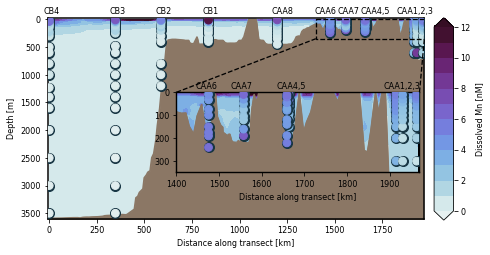

In [21]:
fig, ax = plt.subplots(1,1, figsize=(14,6))

# limits for colorbar:
vminmn = 0 
vmaxmn = 12
pointsbg = '#173543'# outline color for scatterpoints

# plot stations:
for i in range(0,len(transect_lons)):
    ax.scatter(transect_distances_m[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=pointsbg, zorder = 3, s=100)
    sc = ax.scatter(transect_distances_m[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=transect_dMn_r[:,i], cmap=cmocean.cm.dense,\
                       zorder = 3, s=60)
#     ax.text(transect_distances_m[i]-30, -100, transect_names2[i], fontsize=8)
    if i == 5:
        ax.text(transect_distances_m[i]-80, -100, transect_names2[i], fontsize=8)
    elif i==6:
        ax.text(transect_distances_m[i]-45, -100, transect_names2[i], fontsize=8)
    elif i==9:
        ax.text(transect_distances_m[i]-90, -100, transect_names2[i], fontsize=8)
    else:
        ax.text(transect_distances_m[i]-30, -100, transect_names2[i], fontsize=8)
    
ax.invert_yaxis()
contour = ax.contourf(transect_model_distances, depths_model, mn_dis_t*10**(9), np.arange(vminmn,vmaxmn+1), \
               vmin=vminmn, vmax=vmaxmn, cmap=cmocean.cm.dense, extend='both')
ax.plot(transect_distances, transect_bathy, c=land_color)
ax.fill_between(transect_distances, 4000, transect_bathy, color=land_color, zorder=1)
ax.set_ylabel('Depth [m]', fontsize=8)
ax.set_xlabel('Distance along transect [km]', fontsize=8)
ax.set_ylim([3600, -30])
ax.set_xlim([-8, 1970])
ax.tick_params(axis='both', which='major', labelsize=8)
plt.setp(ax.spines.values(), linewidth=1.5, color='k')

# zoom in:
inset_ax = fig.add_axes([.39, .3, .5, .3], facecolor='k')
for i in range(0,len(transect_lons)):
    inset_ax.scatter(transect_distances_m[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=pointsbg, zorder = 3, s=100)
    sc = inset_ax.scatter(transect_distances_m[i]*np.ones(24), transect_depths_r[:,i], \
                       vmin = vminmn, vmax = vmaxmn, c=transect_dMn_r[:,i], cmap=cmocean.cm.dense,\
                       zorder = 3, s=60)
    if i > 4:
        inset_ax.text(transect_distances_m[i]-30, -15, transect_names2[i], fontsize=8)

inset_ax.invert_yaxis()
inset_ax.set_ylim([350, 0])
inset_ax.set_xlim([1400, 1970])
inset_ax.set_xlabel('Distance along transect [km]', fontsize=8)
inset_ax.plot(transect_distances, transect_bathy, c=land_color)
inset_ax.contourf(transect_model_distances, depths_model, mn_dis_t*10**(9), np.arange(vminmn,vmaxmn+1), \
               vmin=vminmn, vmax=vmaxmn, cmap=cmocean.cm.dense, extend='both')
inset_ax.fill_between(transect_distances, 3500, transect_bathy, color=land_color, zorder=1)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
plt.setp(inset_ax.spines.values(), linewidth=1.4, color='k')

cbar_ax = fig.add_axes([0.92, 0.12, 0.04, 0.76])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Dissolved Mn [nM]', fontsize=8) 
cbar_ax.tick_params(axis='both', which='major', labelsize=8)

mark_inset(ax, inset_ax, loc1=2, loc2=1, fc="none", ec='k', lw=1.3, linestyle='--', zorder=4);

figure = plt.gcf()
figure.set_size_inches(4.5*1.5, 3.7)
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/R2-transect.png', \
               bbox_inches='tight', dpi=300)
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/R2-transect.svg', \
               bbox_inches='tight', dpi=300, format='svg')